In [1]:
import keras
import keras.backend as K
from keras.layers import *
from keras.models import Sequential
import tensorflow as tf
import gc
from numba import jit
from IPython.display import display, clear_output
from tqdm import tqdm,tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sys
from keras.callbacks import *
sns.set_style("whitegrid")

Using TensorFlow backend.


## 1. Load Data

In [2]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np

In [3]:
%%time 
train_set = pq.read_pandas('../input/train.parquet').to_pandas()

CPU times: user 41.7 s, sys: 23.5 s, total: 1min 5s
Wall time: 1min 5s


In [4]:
%%time
meta_train = pd.read_csv('../input/metadata_train.csv')

CPU times: user 12 ms, sys: 8 ms, total: 20 ms
Wall time: 19.1 ms


In [5]:
def matthews_correlation(y_true, y_pred):
    '''Calculates the Matthews correlation coefficient measure for quality
    of binary classification problems.
    '''
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)
    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    return numerator / (denominator + K.epsilon())

## 2. Process and Minimize Data

In [6]:
n_part,n_steps = 400,40
n_length = int(n_part/n_steps)
xlength = 800000
pool = np.int32(np.ceil(xlength/n_part))

In [7]:
#@jit('float32(float32[:,:], int32)')
def feature_extractor(x,n_part,n_steps):
    x = x/128
    output = []
    for j, i in enumerate(range(0,xlength, pool)):
        if i+pool < xlength:
            k = x[i:i+pool]
        else:
            k = x[i:]
#         maxv = np.max(k, axis=0)
#         minv = np.min(k, axis=0)
        mean = np.mean(k, axis=0)
        perctentile = np.percentile(k, [0, 1, 5, 15, 25, 50, 75, 85, 95, 99, 100])
        zero_cross = len(np.where(np.diff(np.sign(k-mean)))[0])/pool
        
        output.append(np.concatenate((perctentile,[zero_cross])))
    return np.array(output).reshape(n_steps,n_length,-1)

In [8]:
test = feature_extractor(train_set.iloc[:, 0].values, n_part,n_steps)

In [9]:
test.shape

(40, 10, 12)

In [10]:
x_train = []
y_train = []
idlist=meta_train.id_measurement.unique()
for i in tqdm_notebook(idlist):
    y_train.append(int(meta_train.loc[meta_train.id_measurement==i, 'target'].sum()>0))
    xx=[]
    for phase in [0,1,2]:
        idx = i*3+phase
        xx.append(feature_extractor(train_set.iloc[:, idx].values,n_part,n_steps))
    x_train.append(np.concatenate(xx,axis=2))

In [11]:
print(np.array(x_train).shape,np.array(y_train).shape)

(2904, 40, 10, 36) (2904,)


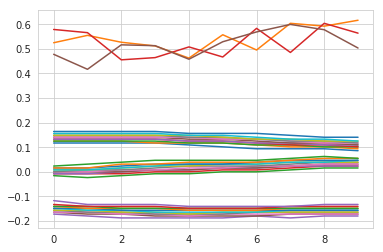

In [12]:
plt.plot(x_train[0][0])

In [13]:
# x_train = []
# y_train = []
# for i in tqdm(meta_train.signal_id):
#     idx = meta_train.loc[meta_train.signal_id==i, 'signal_id'].values.tolist()
#     y_train.append(meta_train.loc[meta_train.signal_id==i, 'target'].values)
#     x_train.append(abs(feature_extractor(train_set.iloc[:, idx].values, n_part=1000)))

In [14]:
del train_set; gc.collect()

0

In [15]:
y_train = np.array(y_train).reshape(-1,)
X_train = np.array(x_train)#.reshape(-1,x_train[0].shape[0])

In [16]:
#X_train.shape[-1]

## 3. Build Primitive CNN + LSTM Model

* CNN is for feature extraction and LSTM is for capturing time dependency.

In [17]:
n_signals = X_train.shape[-1]
n_outputs = 1 #Binary Classification

In [18]:
K.clear_session()
#Build the model
verbose, epochs, batch_size = True, 50, 128
#X_train = X_train.reshape((X_train.shape[0], n_steps, n_length, n_signals))
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_signals)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(Bidirectional(LSTM(128)))#LSTM(100))
#model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
#model.add(Dense(16, activation='relu'))
model.add(Dense(n_outputs, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [19]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[matthews_correlation])

In [20]:
ckpt = ModelCheckpoint('model1.hdf5', save_best_only=True, save_weights_only=True, verbose=1, monitor='val_matthews_correlation', mode='max')
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose,validation_split=0.25,callbacks=[ckpt])

Instructions for updating:
Use tf.cast instead.
Train on 2178 samples, validate on 726 samples
Epoch 1/50
2178/2178 [==============================] - 8s 4ms/step - loss: 0.3581 - matthews_correlation: 0.0000e+00 - val_loss: 0.2971 - val_matthews_correlation: 0.0000e+00

Epoch 00001: val_matthews_correlation improved from -inf to 0.00000, saving model to model1.hdf5
Epoch 2/50
2178/2178 [==============================] - 6s 3ms/step - loss: 0.2603 - matthews_correlation: 0.0000e+00 - val_loss: 0.2231 - val_matthews_correlation: 0.0000e+00

Epoch 00002: val_matthews_correlation did not improve from 0.00000
Epoch 3/50
2178/2178 [==============================] - 6s 3ms/step - loss: 0.2494 - matthews_correlation: 0.0000e+00 - val_loss: 0.2148 - val_matthews_correlation: 0.0000e+00

Epoch 00003: val_matthews_correlation did not improve from 0.00000
Epoch 4/50
2178/2178 [==============================] - 6s 3ms/step - loss: 0.2361 - matthews_correlation: 0.0000e+00 - val_loss: 0.2016 - val_

In [21]:
%%time
meta_test = pd.read_csv('../input/metadata_test.csv')

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 16.8 ms


In [22]:
test = pq.read_pandas('../input/test.parquet',columns=['8715']).to_pandas()
feature_extractor(test['8715'].values,n_part,n_steps).shape    

(40, 10, 12)

In [23]:
x_test = []
idlist=meta_test.id_measurement.unique()
n_slit=10
start = idlist[0]
end = idlist[-1]+1
print(start,end)
Nperpart=int((end-start)/n_slit)
part=[]
while start+Nperpart < end:
    part.append([start,start+Nperpart])
    start += Nperpart
part.append([start,end])

for start,end in part:
    test_set = pq.read_pandas('../input/test.parquet', 
                              columns=[str(i) for i in range(start*3, end*3)]).to_pandas()
    for i in tqdm_notebook(range(start,end)):
        xx=[]
        for phase in [0,1,2]:
            idx = i*3+phase
            xx.append(feature_extractor(test_set[str(idx)].values,n_part,n_steps))
        x_test.append(np.concatenate(xx,axis=2))

2904 9683


In [24]:
del test_set; gc.collect()

20372

In [25]:
X_test=np.asarray(x_test)
X_test.shape

(6779, 40, 10, 36)

In [26]:
model.load_weights('model1.hdf5')
preds = model.predict(X_test)

In [27]:
threshpreds = (preds>0.5)*1

In [28]:
sub = pd.read_csv('../input/sample_submission.csv')
expandpred=[]
for t in threshpreds:
    expandpred+=[t[0],t[0],t[0]]
sub.target = expandpred

In [29]:
sub.to_csv('first_sub.csv',index=False)